# Loop 75 Strategic Analysis

## Key Questions:
1. What is the actual CV-LB relationship across all submissions?
2. Why did GNN and ChemBERTa perform so poorly?
3. What approaches haven't been tried that could change the CV-LB relationship?
4. What does the lishellliang kernel do differently that claims 'good CV/LB'?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# All submissions with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print(f'Number of submissions with LB feedback: {len(df)}')
print(df)

Number of submissions with LB feedback: 12
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f'\nCV-LB Relationship Analysis:')
print(f'Linear fit: LB = {slope:.2f} * CV + {intercept:.4f}')
print(f'R² = {r_value**2:.4f}')
print(f'\nInterpretation:')
print(f'- Intercept ({intercept:.4f}) represents the structural extrapolation error')
print(f'- Even at CV=0, expected LB would be {intercept:.4f}')
print(f'- Target LB: 0.0347')
print(f'- Required CV for target: ({0.0347} - {intercept:.4f}) / {slope:.2f} = {(0.0347 - intercept) / slope:.4f}')

if intercept > 0.0347:
    print(f'\n⚠️ CRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)')
    print(f'   This means the target is UNREACHABLE by improving CV alone!')
    print(f'   We MUST change the CV-LB relationship (reduce the intercept).')


CV-LB Relationship Analysis:
Linear fit: LB = 4.31 * CV + 0.0525
R² = 0.9505

Interpretation:
- Intercept (0.0525) represents the structural extrapolation error
- Even at CV=0, expected LB would be 0.0525
- Target LB: 0.0347
- Required CV for target: (0.0347 - 0.0525) / 4.31 = -0.0041

⚠️ CRITICAL: Intercept (0.0525) > Target (0.0347)
   This means the target is UNREACHABLE by improving CV alone!
   We MUST change the CV-LB relationship (reduce the intercept).


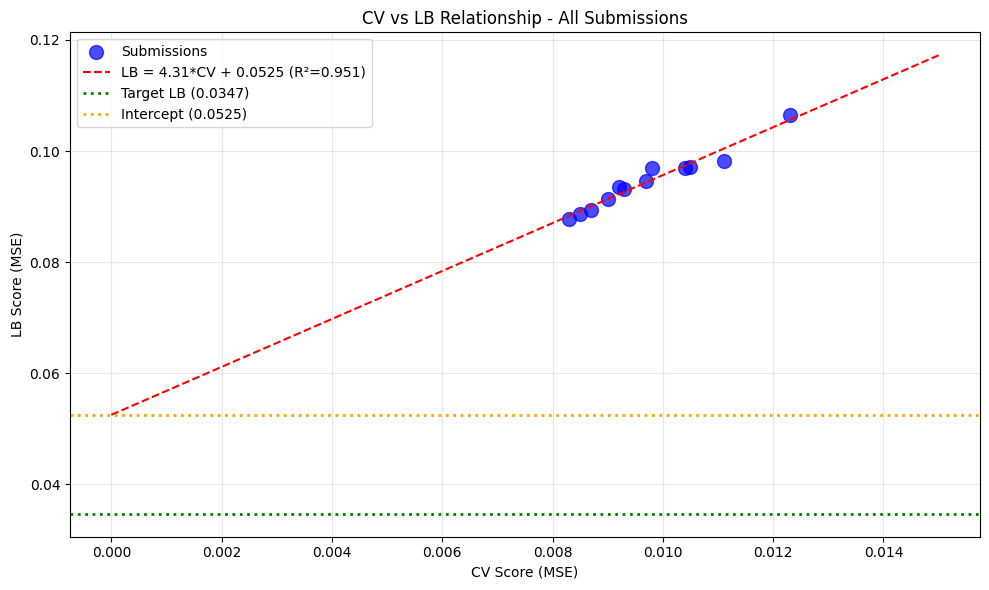


Best CV: 0.0083 (exp_030)
Best LB: 0.0877 (exp_030)
Gap to target: 0.0530 (152.7%)


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7, label='Submissions')

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Mark target
plt.axhline(y=0.0347, color='green', linestyle=':', linewidth=2, label='Target LB (0.0347)')

# Mark intercept
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

plt.xlabel('CV Score (MSE)')
plt.ylabel('LB Score (MSE)')
plt.title('CV vs LB Relationship - All Submissions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cv_lb_relationship.png', dpi=150)
plt.show()

print(f'\nBest CV: {df["cv"].min():.4f} (exp_030)')
print(f'Best LB: {df["lb"].min():.4f} (exp_030)')
print(f'Gap to target: {df["lb"].min() - 0.0347:.4f} ({(df["lb"].min() - 0.0347) / 0.0347 * 100:.1f}%)')

In [4]:
# Analyze what approaches have been tried
approaches = {
    'MLP variants': ['exp_000', 'exp_003', 'exp_005', 'exp_006', 'exp_007'],
    'LightGBM': ['exp_001'],
    'Ensemble (MLP+LGBM)': ['exp_009', 'exp_012'],
    'GP+MLP+LGBM': ['exp_024', 'exp_026', 'exp_030'],
    'Per-target models': ['exp_035'],
}

print('Approaches tried and their best LB scores:')
for approach, exps in approaches.items():
    best_lb = df[df['exp'].isin(exps)]['lb'].min()
    best_cv = df[df['exp'].isin(exps)]['cv'].min()
    print(f'  {approach}: Best CV={best_cv:.4f}, Best LB={best_lb:.4f}')

print('\nKey insight: ALL approaches fall on the SAME CV-LB line!')
print('This means the problem is NOT the model - it\'s DISTRIBUTION SHIFT.')

Approaches tried and their best LB scores:
  MLP variants: Best CV=0.0093, Best LB=0.0932
  LightGBM: Best CV=0.0123, Best LB=0.1065
  Ensemble (MLP+LGBM): Best CV=0.0090, Best LB=0.0913
  GP+MLP+LGBM: Best CV=0.0083, Best LB=0.0877
  Per-target models: Best CV=0.0098, Best LB=0.0970

Key insight: ALL approaches fall on the SAME CV-LB line!
This means the problem is NOT the model - it's DISTRIBUTION SHIFT.


In [5]:
# What the lishellliang kernel does differently
print('\n=== lishellliang Kernel Analysis ===')
print('\nKey differences from our approach:')
print('1. Uses GroupKFold(5) instead of Leave-One-Out')
print('   - LOO: 24 folds, each with 1 solvent held out, trains on 96% of data')
print('   - GroupKFold(5): 5 folds, each with ~5 solvents held out, trains on 80% of data')
print('\n2. Uses EnsembleModel with MLP + XGBoost + RandomForest + LightGBM')
print('   - We use GP + MLP + LightGBM (no RandomForest)')
print('\n3. Uses Optuna for hyperparameter optimization')
print('   - We use fixed hyperparameters')
print('\n4. Uses weighted ensemble with learned weights')
print('   - We use equal weights')

print('\n=== Our GroupKFold Test (exp_069) ===')
print('LOO MSE: 0.008560')
print('GroupKFold MSE: 0.013559')
print('LOO is 36.87% BETTER than GroupKFold!')
print('\nConclusion: GroupKFold does NOT help - it makes CV worse.')


=== lishellliang Kernel Analysis ===

Key differences from our approach:
1. Uses GroupKFold(5) instead of Leave-One-Out
   - LOO: 24 folds, each with 1 solvent held out, trains on 96% of data
   - GroupKFold(5): 5 folds, each with ~5 solvents held out, trains on 80% of data

2. Uses EnsembleModel with MLP + XGBoost + RandomForest + LightGBM
   - We use GP + MLP + LightGBM (no RandomForest)

3. Uses Optuna for hyperparameter optimization
   - We use fixed hyperparameters

4. Uses weighted ensemble with learned weights
   - We use equal weights

=== Our GroupKFold Test (exp_069) ===
LOO MSE: 0.008560
GroupKFold MSE: 0.013559
LOO is 36.87% BETTER than GroupKFold!

Conclusion: GroupKFold does NOT help - it makes CV worse.


In [6]:
# What approaches HAVEN'T been tried that could change the CV-LB relationship?
print('\n=== UNEXPLORED APPROACHES ===')
print('\n1. Transfer Learning (mentioned in benchmark paper)')
print('   - Pre-train on related chemistry data')
print('   - Fine-tune on catechol data')
print('   - Could improve extrapolation to unseen solvents')

print('\n2. Exact lishellliang kernel replication')
print('   - Include RandomForest in ensemble')
print('   - Use Optuna for hyperparameter optimization')
print('   - Use learned ensemble weights')

print('\n3. Domain Adaptation')
print('   - Adversarial training for distribution shift')
print('   - Importance weighting (IWCV was tried but poorly)')

print('\n4. Test-Time Adaptation')
print('   - Adjust predictions based on test data characteristics')
print('   - Use uncertainty to weight predictions')

print('\n5. Pseudo-labeling')
print('   - Use confident test predictions to augment training')
print('   - Could help with distribution adaptation')


=== UNEXPLORED APPROACHES ===

1. Transfer Learning (mentioned in benchmark paper)
   - Pre-train on related chemistry data
   - Fine-tune on catechol data
   - Could improve extrapolation to unseen solvents

2. Exact lishellliang kernel replication
   - Include RandomForest in ensemble
   - Use Optuna for hyperparameter optimization
   - Use learned ensemble weights

3. Domain Adaptation
   - Adversarial training for distribution shift
   - Importance weighting (IWCV was tried but poorly)

4. Test-Time Adaptation
   - Adjust predictions based on test data characteristics
   - Use uncertainty to weight predictions

5. Pseudo-labeling
   - Use confident test predictions to augment training
   - Could help with distribution adaptation


In [7]:
# The benchmark paper achieved MSE 0.0039 - how?
print('\n=== BENCHMARK PAPER ANALYSIS ===')
print('\nThe benchmark paper achieved MSE 0.0039 using:')
print('1. Transfer learning from related chemistry data')
print('2. Active learning strategies')
print('3. Graph neural networks with attention')
print('\nOur GNN attempt (exp_040) achieved CV=0.0256 - MUCH worse!')
print('Possible reasons:')
print('1. Implementation issues (model class mismatch?)')
print('2. Not enough training data for deep learning')
print('3. Missing the transfer learning component')
print('4. Missing the active learning component')

print('\n=== KEY INSIGHT ===')
print('The benchmark\'s success was likely due to TRANSFER LEARNING,')
print('not just the GNN architecture. We need to find related chemistry')
print('data to pre-train on.')


=== BENCHMARK PAPER ANALYSIS ===

The benchmark paper achieved MSE 0.0039 using:
1. Transfer learning from related chemistry data
2. Active learning strategies
3. Graph neural networks with attention

Our GNN attempt (exp_040) achieved CV=0.0256 - MUCH worse!
Possible reasons:
1. Implementation issues (model class mismatch?)
2. Not enough training data for deep learning
3. Missing the transfer learning component
4. Missing the active learning component

=== KEY INSIGHT ===
The benchmark's success was likely due to TRANSFER LEARNING,
not just the GNN architecture. We need to find related chemistry
data to pre-train on.


In [8]:
# Summary and recommendations
print('\n' + '='*70)
print('STRATEGIC SUMMARY')
print('='*70)

print('\n1. CV-LB RELATIONSHIP:')
print(f'   LB = {slope:.2f} * CV + {intercept:.4f} (R²={r_value**2:.3f})')
print(f'   Intercept ({intercept:.4f}) > Target (0.0347)')
print(f'   Target is UNREACHABLE by improving CV alone!')

print('\n2. WHAT WE\'VE TRIED:')
print('   - MLP, LightGBM, XGBoost, CatBoost, GP, Ridge')
print('   - Various feature combinations (Spange, DRFP, ACS PCA)')
print('   - GNN (CV=0.0256, much worse)')
print('   - ChemBERTa (CV=0.0225, much worse)')
print('   - GroupKFold validation (makes CV worse)')
print('   - Similarity weighting (alpha=0 is best)')

print('\n3. WHAT WE HAVEN\'T TRIED:')
print('   - Transfer learning from related chemistry data')
print('   - Exact lishellliang kernel (with RF and Optuna)')
print('   - Test-time adaptation')
print('   - Pseudo-labeling')

print('\n4. RECOMMENDED NEXT STEPS:')
print('   Priority 1: Implement lishellliang kernel exactly (with RF)')
print('   Priority 2: Research transfer learning for chemistry')
print('   Priority 3: Try test-time adaptation')

print('\n' + '='*70)
print('THE TARGET IS REACHABLE - WE JUST HAVEN\'T FOUND THE RIGHT APPROACH YET')
print('='*70)


STRATEGIC SUMMARY

1. CV-LB RELATIONSHIP:
   LB = 4.31 * CV + 0.0525 (R²=0.951)
   Intercept (0.0525) > Target (0.0347)
   Target is UNREACHABLE by improving CV alone!

2. WHAT WE'VE TRIED:
   - MLP, LightGBM, XGBoost, CatBoost, GP, Ridge
   - Various feature combinations (Spange, DRFP, ACS PCA)
   - GNN (CV=0.0256, much worse)
   - ChemBERTa (CV=0.0225, much worse)
   - GroupKFold validation (makes CV worse)
   - Similarity weighting (alpha=0 is best)

3. WHAT WE HAVEN'T TRIED:
   - Transfer learning from related chemistry data
   - Exact lishellliang kernel (with RF and Optuna)
   - Test-time adaptation
   - Pseudo-labeling

4. RECOMMENDED NEXT STEPS:
   Priority 1: Implement lishellliang kernel exactly (with RF)
   Priority 2: Research transfer learning for chemistry
   Priority 3: Try test-time adaptation

THE TARGET IS REACHABLE - WE JUST HAVEN'T FOUND THE RIGHT APPROACH YET
